# Project Goal

The goal in monocular depth estimation is to predict the depth value of each pixel or to infer general depth information, given only one single RGB image as input. In the example picture below, the leftmost column is RGB images, and the middle row is depth information maps of the corresponding images.

As you may have experienced, this task isn’t so difficult for human eyes, but it still remains somewhat challenging for robots’ perception modules. It’s not hard to imagine the value depth estimation can bring: autonomous vehicles can be more aware of their distance to obstacles, factory robots can know better about the things they manipulate, etc. Roboticists in industry and academia care about this question a lot.


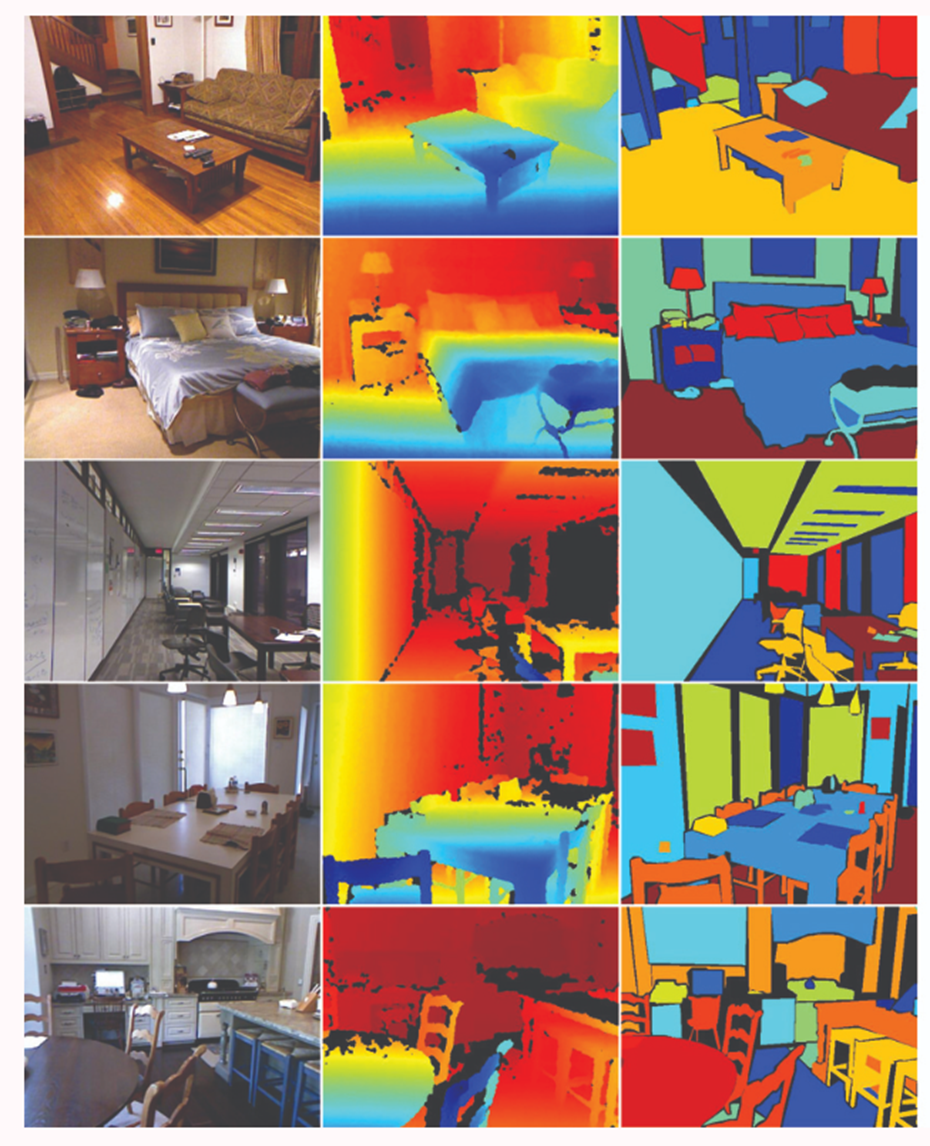

# 0. Introduction and Importing

First, we import the most fundamental packages/modules of PyTorch.

In [303]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import numpy as np
from torch.utils.data import random_split
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision.models import resnet18

Import some generic helper packages

In [304]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import cv2


Pytorch essentially does two things:
- Manipulates the so-called tensor data structure on GPU, just like NumPy can manipulate ndarray on CPU.
- Provides a automatic differentiation engine and some convenient helper functions for deep learning

Tensor is a data structure that can be thought of as a generalization of a matrix. A grayscale image is a matrix, but a colored image with 3 channels can be thought of a tensor.

Check if we are using GPU. Computation will be very slow if not.

In [305]:
torch.cuda.is_available()

True

The code sets a seed for the random number generators used by the random module, the numpy library, and the PyTorch library. By setting a seed, the code ensures that the results of the random number generation will be deterministic and reproducible, meaning that each time the code is run, the same sequence of random numbers will be generated. This is useful for debugging and testing, as well as for reproducing experimental results.

Additionally, the code sets the device to either the GPU (if available) or the CPU. The PyTorch library allows computations to be performed on either the GPU or the CPU, and the device to be used can be specified by setting the device variable.

Finally, the code sets torch.backends.cudnn.deterministic to True. This flag controls the deterministic behavior of the cuDNN library, which is used by PyTorch for GPU acceleration. By setting this flag to True, the code ensures that the cuDNN library will produce deterministic results and further improves the reproducibility of the code.

In [306]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Dataset analysis

In [307]:
import os
data_path="../dataset/sync/"

# Get all image file paths in the dataset
rgb_image_paths = []
depth_image_paths = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.jpg'):
            rgb_image_paths.append(os.path.join(root, file))
        if file.endswith('.png'):
            depth_image_paths.append(os.path.join(root, file))

print(f'Total RGB images: {len(rgb_image_paths)}')
print(f'Total Depth images: {len(depth_image_paths)}')


Total RGB images: 36396
Total Depth images: 36396


In [308]:
import cv2

# Choose a sample image from the dataset
sample_rgb_path = os.path.join(data_path, 'basement_0001a', 'rgb_00000.jpg')
sample_depth_path = os.path.join(data_path, 'basement_0001a', 'sync_depth_00000.png')

# Load the sample RGB image and get its resolution and format
rgb_image = cv2.imread(sample_rgb_path)
rgb_height, rgb_width, rgb_channels = rgb_image.shape
rgb_format = sample_rgb_path.split('.')[-1]

# Load the sample depth image and get its resolution and format
depth_image = cv2.imread(sample_depth_path, cv2.IMREAD_ANYDEPTH)
depth_height, depth_width = depth_image.shape
depth_format = sample_depth_path.split('.')[-1]


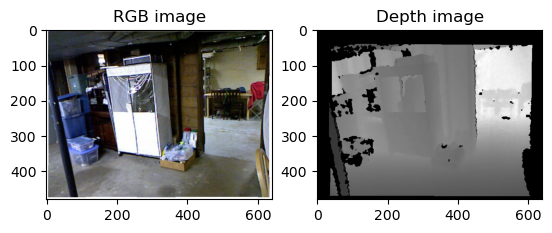

In [309]:
# Load the sample RGB image and get its resolution and format
rgb_image = cv2.imread(sample_rgb_path)
rgb_height, rgb_width, rgb_channels = rgb_image.shape
rgb_format = sample_rgb_path.split('.')[-1]

# Load the sample depth image and get its resolution and format
depth_image = cv2.imread(sample_depth_path, cv2.IMREAD_ANYDEPTH)
depth_height, depth_width = depth_image.shape
depth_format = sample_depth_path.split('.')[-1]

# Plot the RGB and depth images
fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('RGB image')
axs[1].imshow(depth_image, cmap='gray')
axs[1].set_title('Depth image')
plt.show()

Depth map statistics

Warning: takes very long to run because of the large dataset size

In [310]:
# import os
# import cv2
# import numpy as np


# # Collect all depth values from the dataset
# depth_values = []
# for depth_path in depth_image_paths:
#     depth_image = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
#     depth_values.extend(depth_image.flatten())

# # Filter out invalid depth values
# valid_depth_values = np.array(depth_values)[np.array(depth_values) != 0]

# # Compute basic statistics about the depth values
# print(f'Processed {len(depth_image_paths)} depth images')
# print('Minimum depth value:', np.min(valid_depth_values))
# print('Maximum depth value:', np.max(valid_depth_values))
# print('Median depth value:', np.median(valid_depth_values))
# print('Mean depth value:', np.mean(valid_depth_values))


Now let's work on our own model. A MLP (Multi-Layer Perceptron, aka Neural Network) on the NYU Depth V2.

We will train out MLP on a custom NYU Depth V2 dataset. 


In [311]:
class MonocularDepthDataset(Dataset):
    def __init__(self, data_path, transforms_rgb=None, transforms_depth=None):
        self.data_path = data_path
        self.transforms_rgb = transforms_rgb
        self.transforms_depth = transforms_depth

        self.rgb_filenames = []
        self.depth_filenames = []
        for folder in sorted(glob.glob(os.path.join(data_path, "*"))):
            self.rgb_filenames.extend(sorted(glob.glob(os.path.join(folder, "rgb_*.jpg"))))
            self.depth_filenames.extend(sorted(glob.glob(os.path.join(folder, "sync_depth_*.png"))))
            
    def __getitem__(self, index):
        rgb = Image.open(self.rgb_filenames[index])
        depth = Image.open(self.depth_filenames[index])

        if self.transforms_rgb:
            rgb = self.transforms_rgb(rgb)

        if self.transforms_depth:
            # Convert depth image to float
            depth = np.array(depth).astype(np.float32)
            depth = Image.fromarray(depth)

            depth = self.transforms_depth(depth)

        return rgb, depth

    def __len__(self):
        return len(self.rgb_filenames)


### Normalization and Standardization

To put it simple:

***normalize***: making your data range in [0, 1]

**standardize**: making your data's mean=0 and std=1

In modern deep learning, sometimes it's often okay if you don't do these, but they will often help with faster training and better accuracy. Please see this [article](https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn).

Calculate the mean and standard deviation of pixel values so we can standardize the dataset later. 


TODO: remove hardcoded values and calculate mean and std

train_dataset = train_dataset.data.float()
means = train_dataset.data.mean(axis = (0)) / 255
stds = train_dataset.data.std(axis = (0)) / 255

In [312]:
# TODO fix the normalization

IMG_HEIGHT = 224
IMG_WIDTH = 224

# Define transformations for the RGB images
transform_rgb = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for the depth images
transform_depth = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create an instance of the dataset
depth_dataset = MonocularDepthDataset(data_path="../dataset/sync/", transforms_rgb=transform_rgb, transforms_depth=transform_depth)

In [313]:
# ! IMPORTANT- remove this after debugging
# ! Take 100 random images
# Create a list of indices
indices = list(range(len(depth_dataset)))

# Sample 100 random indices
random_indices = random.sample(indices, 100)

# Create a new dataset with the selected images
depth_dataset = [depth_dataset[i] for i in random_indices]

In [314]:
# import torch.utils.data as data

# # Create a SubsetRandomSampler
# num_samples = 10000
# indices = list(range(len(depth_dataset)))
# subset_indices = random.sample(indices, num_samples)
# depth_dataset = data.SubsetRandomSampler(subset_indices)


### Data Loading and Pre-processing

Leave out 10% of data from the training set as the validation set. **The model won't train on the validation set, but only do inference on it.** 

Validation set is similar to test set (hence the similar transformations), but it's a good practice to only run your model on test set for only **once**, and use your validation set as a gauge of how well your model generalize while tweaking hyper-parameters

In [315]:

# Determine the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the number of samples for each split
total_samples = len(depth_dataset)
train_samples = int(train_ratio * total_samples)
val_samples = int(val_ratio * total_samples)
test_samples = total_samples - train_samples - val_samples

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(depth_dataset, [train_samples, val_samples, test_samples])


In [316]:
print("Size of training set", len(train_dataset))
print("Size of validation set", len(val_dataset))
print("Size of test set", len(test_dataset))

Size of training set 29116
Size of validation set 3639
Size of test set 3641


### Data Augmentation

TODO confirm if we should do since dataset is big enough

Next, we will do data augmentation. DL models are data hungry. A good trick to increse the size of dataset without the hardwork of acquiring/labeling more data is data augmentation. 

For each training image we will randomly rotate it (by up to 5 degrees), flip/mirror with probability 0.5, shift by +/-1 pixel. 

In [317]:
...

# here we compose all the data augmentation actions we want to do.
# note that there is no need to do data augmentation on the testing set.
# train_transforms = [torchvision.transforms.RandomRotation(5),
#                   torchvision.transforms.RandomHorizontalFlip(0.5),
#                   torchvision.transforms.ToTensor()]

Ellipsis

The final step is to create a DataLoader object. 

DataLoader object can be thought of as an iterator we use in Python. Deep learning dataset are usually too large to fit on memory (RAM, usually 8GB to 32GB) entirely, so we want to have a DataLoader that can spit out a fixed size of the dataset every time we need more data to process.

Batch_size can be thought of the number of data point we will ask the DataLoader to spit out. After DataLoader spit out a chunk partitioned from the entire dataset, we will send it to GPU's memory (VRAM) so GPU can work on it. Similarly, GPU has limited memory, usually ranging from a few GB to 40GB, so the number should be adjusted according to the VRAM of your GPU.

In [318]:
BATCH_SIZE = 32

# Create DataLoader objects for each split
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Test data loader and check for GPU

Additionally, the code sets the device to either the GPU (if available) or the CPU. The PyTorch library allows computations to be performed on either the GPU or the CPU, and the device to be used can be specified by setting the device variable.

RGB shape: torch.Size([3, 224, 224])
Depth shape: torch.Size([1, 224, 224])


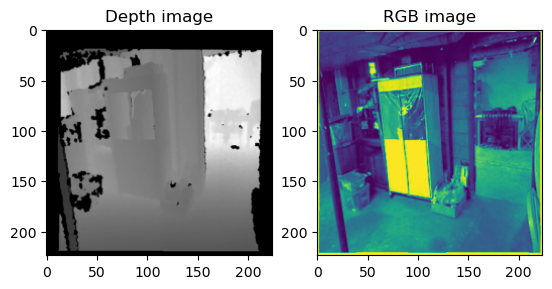

In [319]:
import matplotlib.pyplot as plt

# Get the first batch of data from the DataLoader
rgb, depth = next(iter(depth_dataset))
# depth, rgb = next(iter(depth_dataset))
# depth, rgb = next(iter(depth_dataset)) # get the third batch

# Print the shape of the first batch of depth and RGB images
print("RGB shape:", rgb.shape)

print("Depth shape:", depth.shape)

# Plot the first depth and RGB images in the batch

plt.subplot(1, 2, 2)

plt.imshow(rgb[0].unsqueeze(0).permute(1, 2, 0))
plt.title("RGB image")

plt.subplot(1, 2, 1)
plt.imshow(depth[0], cmap='gray')
plt.title("Depth image")

plt.show()


# Step 1: Model

The code provided defines a custom deep learning model called `DepthResNet` that builds on top of the pre-trained ResNet-18 architecture. The purpose of this model is to estimate depth maps from input RGB images.

Here's the thinking behind this implementation:

1. **Inheriting from `nn.Module`:** The `DepthResNet` class inherits from PyTorch's `nn.Module` class. This allows the custom model to use the features and functionalities of the base `nn.Module` class, which is the foundation of all PyTorch models.

2. **Loading and modifying the pre-trained ResNet-18 model:**
    - The model first loads a pre-trained ResNet-18 model using `resnet18(pretrained=True)`.
    - The original first convolutional layer is replaced with a new one (`self.resnet.conv1`) to accept 3-channel (RGB) images. This is done by setting the input channels to 3.

3. **Removing the classification head:**
    - The original fully connected layer (classification head) is removed from the ResNet-18 model, as it's not needed for depth estimation. This is achieved by slicing the children layers of the model and excluding the last two layers.

4. **Adding upsampling and convolutional layers:**
    - To generate a depth map with the same spatial dimensions as the input image, a series of upsampling layers (using `nn.Upsample` with bilinear interpolation) and convolutional layers are added.
    - The upsampling layers increase the spatial dimensions of the feature maps, while the convolutional layers (with 3x3 kernels and padding) process the features.

5. **Defining the forward pass:**
    - In the `forward` method, the input `x` is passed through the modified ResNet-18 model (without the classification head).
    - Then, `x` is upsampled and passed through the custom convolutional layers to generate the depth map.

The resulting `DepthResNet` model takes an input RGB image and outputs a depth map, which is a single-channel image with the same spatial dimensions as the input. The depth map contains the estimated depth values for each pixel in the input image.


In [320]:
class DepthResNet(nn.Module):
    def __init__(self):
        super(DepthResNet, self).__init__()
        self.resnet = resnet18(pretrained=True)
        
        CONV_KERNEL_SIZE = 3
        CONV_PADDING = 1

        
        # Load the pre-trained ResNet-18 model and modify its first convolutional layer to accept 
        # 3-channel (RGB) images
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove the fully connected layer (also called the classification head) from the original 
        # ResNet-18 model since we're going to replace it with our custom depth estimation layers
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Add upsampling and convolutional layers to generate a depth map with the same spatial dimensions 
        # as the input image. We use nn.Upsample with bilinear interpolation to upscale the feature maps 
        # and a series of convolutional layers with 3x3 kernels and padding to maintain spatial dimensions
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=CONV_KERNEL_SIZE, padding=CONV_PADDING)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=CONV_KERNEL_SIZE, padding=CONV_PADDING)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=CONV_KERNEL_SIZE, padding=CONV_PADDING)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=CONV_KERNEL_SIZE, padding=CONV_PADDING)
        self.conv5 = nn.Conv2d(32, 1, kernel_size=CONV_KERNEL_SIZE, padding=CONV_PADDING)

    def forward(self, x):
        # Perform upsampling and pass the output through the custom convolutional layers to 
        # generate the depth map. The upsampling layers increase the spatial dimensions of the 
        # feature maps, while the convolutional layers process the features
        x = self.resnet(x)
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.conv4(x)
        x = self.upsample(x)
        x = self.conv5(x)
        
        return x

In [321]:
depth_model = DepthResNet()

# Check the model architecture
print(depth_model)

DepthResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

c:\Users\gaura\.conda\envs\robot_vision_class\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gaura\.conda\envs\robot_vision_class\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 3. Training the Model

In [322]:
# Check if a GPU is available and use it if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0



Before we start the training, we will need to initialize our models. To put it simple, we are assigning the intial values of weight. We could just assign them all 0 to start with, and it would work. But data scientists have come up with smarter ways to to this to make things work even better. 

Since the ResNet-18 model is already pre-trained, we don't need to initialize its layers. However, we should initialize the custom upsampling and convolutional layers that we added. For the convolutional layers, we use the *Xavier Normal scheme*, also known as *Glorot Normal*. We initialize the bias terms to zeros.

In [323]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [324]:
depth_model.conv1.apply(initialize_parameters)
depth_model.conv2.apply(initialize_parameters)
depth_model.conv3.apply(initialize_parameters)
depth_model.conv4.apply(initialize_parameters)
depth_model.conv5.apply(initialize_parameters)

Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [325]:
# Move the model to the device
model = depth_model.to(device)

Next we create a optimizer and loss function.

Here the optimzer is called Adam. It's a slightly more advanced version of the common optimization algorithm called gradient descent. There are a few other optimizers out there, but for most common tasks we will just use Adam.

In [326]:
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

For monocular depth estimation, we are dealing with a regression problem. The goal is to predict continuous depth values for each pixel in the image.

Wu should use a loss function designed for regression tasks. Here are some common choices for regression problems:

1. *Mean Squared Error (MSE) loss*. The MSE loss computes the average squared difference between the predicted and target values. The lower the MSE, the better the model performs.
2. *L1 loss* (also known as mean absolute error or MAE). L1 loss as a loss function is also a valid choice for regression problems like monocular depth estimation. It measures the absolute difference between predicted and target depth values.
3. *The BerHu (Bidirectional Huber) loss*. Another popular choice for depth estimation tasks is the BerHu loss, which combines the benefits of L1 loss (mean absolute error) and L2 loss (mean squared error) by applying a threshold to switch between them.
```
BerHu(x) = |x|, if |x| <= c
           (x^2 + c^2) / (2*c), otherwise
```
Here, x represents the difference between the predicted and target values, and c is a threshold value. When the absolute error (|x|) is smaller than or equal to the threshold c, the BerHu loss acts like the L1 loss. When the absolute error is larger than c, the BerHu loss acts like a smoothed version of the L2 loss.

The advantage of using the BerHu loss is that it is less sensitive to outliers than the L2 loss, while still providing a smooth, differentiable loss function when errors are large. This can lead to more robust models, especially in cases where the data is noisy or contains large errors.

Regardless of the loss function we choose, we beed to make sure to monitor the training and validation loss to ensure that the model is learning properly. We experiment with different loss functions to find the one that works best for your specific task.



In [327]:
class BerHuLoss(nn.Module):
    def __init__(self, threshold=0.2):
        super(BerHuLoss, self).__init__()
        self.threshold = threshold

    def forward(self, pred, target):
        abs_error = torch.abs(pred - target)
        mask = abs_error <= self.threshold
        loss = torch.where(mask, abs_error, (abs_error ** 2 + self.threshold ** 2) / (2 * self.threshold))
        return loss.mean()

In [328]:
# criterion = BerHuLoss()

# criterion = nn.L1Loss()

criterion = nn.MSELoss()

In [329]:
criterion = criterion.to(device)

For monocular depth estimation, the accuracy isn't calculated the same way as in classification tasks. You can use evaluation metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), or other depth-specific metrics.

In [330]:
# ! RMSE
def calculate_accuracy(y_pred, y):
    mse = torch.pow(y_pred - y, 2).mean()
    rmse = torch.sqrt(mse)
    return rmse

Set the model to training mode with model.train(). Some layers behave differently during training and testing.
For each iteration:

1. Acquire a batch of (rgb, depth) pairs from the data loader.
2. Send the acquired data to the GPU.
3. Clear the gradients calculated from the last iteration using `optimizer.zero_grad()`.
Pass the batch of RGB images through the model to obtain depth predictions.
1. Calculate the loss between the depth predictions and the actual depth values using the specified criterion.
2. Calculate the accuracy between the depth predictions and the actual depth values using the calculate_accuracy function.
3. Perform the backward pass to calculate gradients for each parameter (backpropagation).
4. Update the parameters by taking an optimizer step with `optimizer.step()`.
5. Accumulate the loss and accuracy values for the current epoch.
6. Finally, return the average epoch loss and accuracy by dividing the accumulated values by the number of iterations in the iterator.

In [331]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for i, (rgb, depth) in enumerate(iterator):
        # Move the data to the device
        rgb = rgb.to(device)
        depth = depth.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
                
        # Forward pass
        depth_pred = model(rgb)
        
        # TODO add accumulation_steps if GPU memory is insufficient
        loss = criterion(depth_pred, depth)
        acc = calculate_accuracy(depth_pred, depth)

        # Backward pass
        loss.backward()
        
        optimizer.step()
        
        # * add .item() for both accuracy and loss to convert the values 
        # * from PyTorch tensors to Python numbers (scalars)
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The evaluation loop is similar to the training loop with a few differences:

1. We put our model into evaluation mode with `model.eval()` as some layers may have different behavior during training and testing (e.g., dropout, batch normalization).
2. We wrap the iterations inside a with `torch.no_grad()` context because, during evaluation, we no longer need to calculate gradients, which saves memory and computational time.
3. We do not need to update our optimizer because we are no longer optimizing our model.

Calculate both the average loss and the average accuracy of the model. 

This can be more informative as it provides an additional metric (accuracy) to assess the model's performance. 

In this case, the accuracy is calculated using the `calculate_accuracy` function, which computes the Root Mean Squared Error (RMSE) between the predicted depth map and the ground truth depth map.



In [332]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_accuracy = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (rgb, depth) in iterator:
            # Move the data to the device
            rgb = rgb.to(device)
            depth = depth.to(device)

            depth_pred = model(rgb)

            loss = criterion(depth_pred, depth)

            accuracy = calculate_accuracy(depth_pred, depth)

            # * add .item() for both accuracy and loss to convert the values 
            # * from PyTorch tensors to Python numbers (scalars)
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()
        
    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)

In [333]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally we can start training. 

For each epoch, we run through the training process once to update our model. It's important to notice that the entire dataset is being run through once for just 1 training process. Then we use the updated model to run through the evaluation process to get our validation accuracy to gauge how well our model generalizes.

We repeat this for 20 epochs here

In [334]:
EPOCHS = 20

# used to record history of the traning
train_loss_history = []
train_accuracy_history = []
validation_loss_history = []
validation_accuracy_history = []

for epoch in range(EPOCHS):
    start_time = time.time() # record start time

    train_loss, train_acc = train(model=model, 
                                    iterator=train_dataloader, 
                                    optimizer=optimizer, 
                                    criterion=criterion, 
                                    device=device)
    
    torch.save(model, './models/model_'+str(epoch)+'.pt')
    
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_acc)
    
    validation_loss, validation_accuracy = evaluate(model=model, 
                                 iterator=val_dataloader, 
                                 criterion=criterion, 
                                 device=device)
    
    validation_loss_history.append(validation_loss) 
    validation_accuracy_history.append(validation_accuracy)
    end_time = time.time()
    minute, second = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1}/{EPOCHS}') 
    print(f'Training Loss: {train_loss}.. Validation Loss: {validation_loss}')
    print(f'Training Accuracy: {train_acc}.. Validation Accuracy: {validation_accuracy}')
    print(f'Time Elapsed: {minute} in minute.. {second} in second')
    print('')

Epoch: 1/20
Training Loss: 4861168.164285715.. Validation Loss: 4053947.379385965
Training Accuracy: 2178.19210661165.. Validation Accuracy: 2007.5755186917488
Time Elapsed: 12 in minute.. 55 in second

Epoch: 2/20
Training Loss: 3364986.2964285715.. Validation Loss: 3120059.2192982454
Training Accuracy: 1826.7884502704328.. Validation Accuracy: 1759.7718345240544
Time Elapsed: 7 in minute.. 32 in second

Epoch: 3/20
Training Loss: 3021565.0652472526.. Validation Loss: 3063276.41995614
Training Accuracy: 1730.2204419481886.. Validation Accuracy: 1743.772953501919
Time Elapsed: 7 in minute.. 23 in second

Epoch: 4/20
Training Loss: 2862706.950824176.. Validation Loss: 2920798.3114035088
Training Accuracy: 1684.9682626577523.. Validation Accuracy: 1702.4895694130346
Time Elapsed: 7 in minute.. 24 in second

Epoch: 5/20
Training Loss: 2752303.6728021977.. Validation Loss: 2794368.8015350876
Training Accuracy: 1651.6507203489869.. Validation Accuracy: 1665.129896732799
Time Elapsed: 7 in m

In this case, "Average Validation Loss" and "Average Validation Accuracy" represent two different ways of evaluating your model's performance on the validation dataset:

Average Validation Loss: This is the average of the L2 loss (mean squared error) between the predicted depth maps and the ground truth depth maps. A lower value for the loss indicates that the model is performing better. However, it's not easy to interpret the loss value in isolation. We should compare it to the loss values of other models or baselines on the same dataset to get an idea of how well our model is performing.

Average Validation Accuracy: In this context, the term "accuracy" might be misleading, as it's not a classification accuracy. Instead, it represents the average RMSE (root mean squared error) between the predicted depth maps and the ground truth depth maps. A lower RMSE value indicates better performance. Like the loss, the RMSE value should be compared to the RMSE values of other models or baselines on the same dataset to understand your model's performance.

It's important to note that both the loss and the RMSE values are not bounded, so we cannot interpret them as percentages. When comparing your model's performance to others or baselines, make sure to use the same metric (loss or RMSE) for a fair comparison.

In [335]:
# Evaluate the model on the validation dataset
val_loss = evaluate(model, val_dataloader, criterion, device)
print(f"Average Validation loss: {val_loss[0]:.4f}")
print(f"Average Validation Accuracy: {val_loss[1]:.4f}")
# Validation loss: 14197389.0000

Average Validation loss: 2165326.1837
Average Validation Accuracy: 1465.4468


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


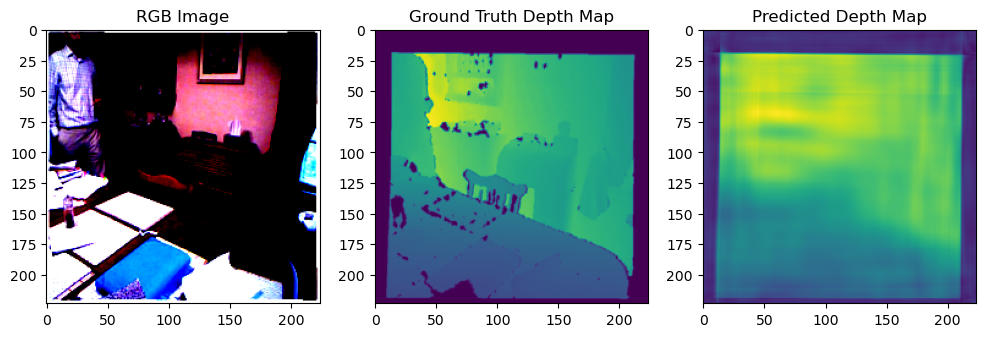

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


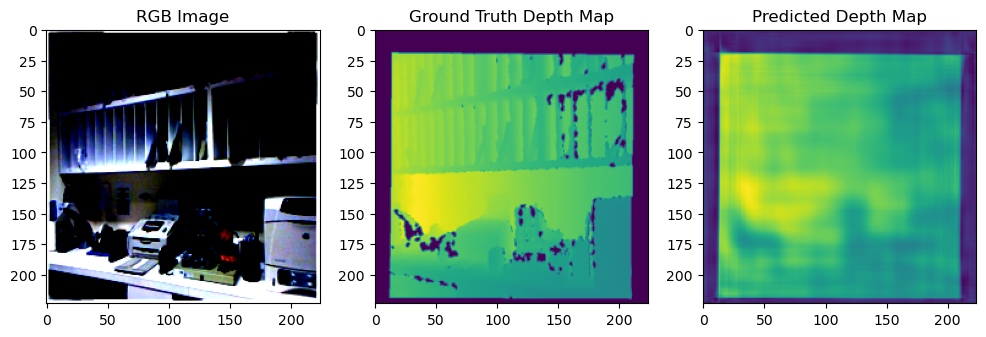

In [336]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Get a batch of data from the validation dataset
rgb_batch, depth_batch = next(iter(val_dataloader))

# Move the batch to the device
rgb_batch = rgb_batch.to(device)

# Predict the depth maps
with torch.no_grad():
    predicted_depth_batch = model(rgb_batch)

# Move the predictions back to the CPU
predicted_depth_batch = predicted_depth_batch.cpu()

# Number of images to visualize
num_images = 2

# Visualize the RGB images, ground truth depth maps, and predicted depth maps
for i in range(num_images):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    # Display the RGB image
    ax1.imshow(rgb_batch[i].permute(1, 2, 0).cpu().numpy())
    ax1.set_title("RGB Image")

    # Display the ground truth depth map
    ax2.imshow(depth_batch[i].squeeze().cpu().numpy(), cmap="viridis")
    ax2.set_title("Ground Truth Depth Map")

    # Display the predicted depth map
    ax3.imshow(predicted_depth_batch[i].squeeze().cpu().numpy(), cmap="viridis")
    ax3.set_title("Predicted Depth Map")

    plt.show()


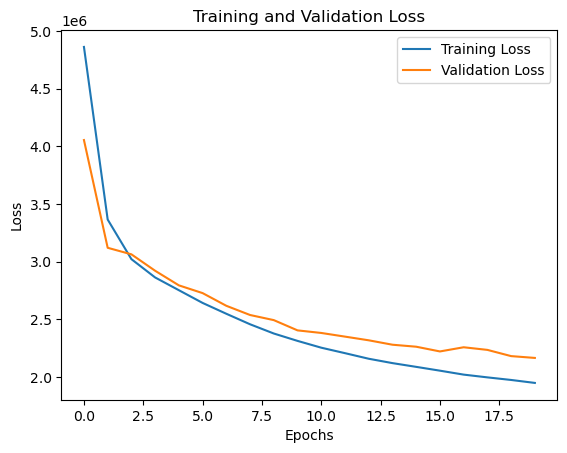

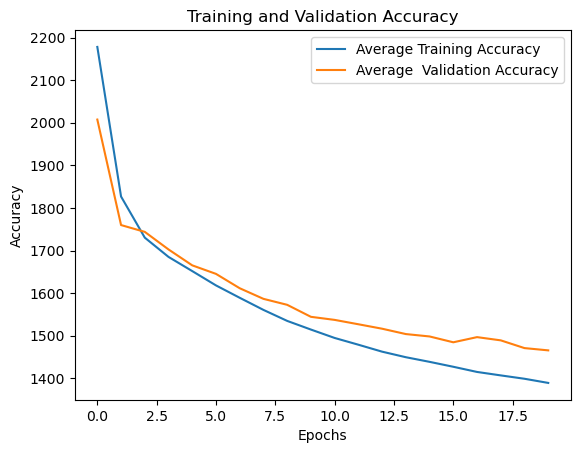

In [337]:
import matplotlib.pyplot as plt

# plot the training and validation loss
plt.plot(train_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.plot(train_accuracy_history, label='Average Training Accuracy')
plt.plot(validation_accuracy_history, label='Average  Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [338]:
best_model_filepath = './models/model_' + str(EPOCHS - 1) + '.pt'
test_model = DepthResNet()
test_model = torch.load(best_model_filepath, map_location=device)
test_model = test_model.to(device)

In [339]:
_, test_acc = evaluate(model=test_model, 
                        iterator=test_dataloader, 
                        criterion=criterion, 
                        device=device)

print('Our Average Test accuracy is:', test_acc)

Our Average Test accuracy is: 1445.4974980939899


# Evaluation

In abs rel, the error is relative to the magnitude of the ground truth itself. Basically, if the magnitude of the ground truth is large, then off by a small amount is no big deal.

In [340]:
def evaluate_check(dataloader, model, device, metric_fn):
    # Switch the model to evaluation mode
    model.eval()

    # Iterate over the test dataset
    with torch.no_grad():
        metric_sum = 0
        count = 0
        for rgb, depth in dataloader:
            # Move the data to the device
            rgb = rgb.to(device)
            depth = depth.to(device)

            # Get the predicted depth map
            depth_pred = model(rgb)

            # Calculate the metric for this image
            metric = metric_fn(depth_pred, depth)

            # Update the metric sum and count
            metric_sum += metric.item() * rgb.size(0)
            count += rgb.size(0)

    # Calculate the average metric for all images in the dataset
    avg_metric = metric_sum / count

    return avg_metric


In [341]:
def root_mean_square_error(depth_pred, depth):
    diff = torch.pow(depth - depth_pred, 2)
    
    numerator = torch.sum(diff)
    denominator = torch.numel(diff)
    return torch.pow( numerator / denominator, 0.5)


def absolute_relative_difference(depth_pred, depth):
    diff = torch.abs(depth - depth_pred) / depth
    diff = diff[~torch.isnan(diff)]  # Remove NaN values
    
    return torch.sum(diff) / torch.numel(diff)


def threshold_check(depth_pred, depth, threshold=1.25):
    check = torch.max(depth / depth_pred, depth_pred / depth)
    numerator = torch.where(check < threshold, 1, 0).sum()
    denominator = check.numel()
    return (numerator / denominator) * 100


In [342]:
rmse = evaluate_check(test_dataloader, test_model, device, root_mean_square_error)
abs_rel_diff = evaluate_check(test_dataloader, test_model, device, absolute_relative_difference)
thresh_check = evaluate_check(test_dataloader, test_model, device, lambda dp, d: threshold_check(dp, d, threshold=1.25))


In [343]:
print(f"Root Means Squared on Test set: {rmse}")
print(f"Absolute Relative Difference on Test set: {abs_rel_diff}")
print(f"Threshold check on Test set: {thresh_check:.2f}%")

Root Means Squared on Test set: 1446.4583124853823
Absolute Relative Difference on Test set: inf
Threshold check on Test set: 75.22%
